In [76]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import time
from scipy.spatial.distance import cdist

# Get data
train_data_small = pd.read_csv(r"MNIST_train_small.csv")
test_data_small = pd.read_csv(r"MNIST_test_small.csv")

def custom_mode(object):
    modes = object.mode()
    # If modes is a Series, take the first value; if it's a single value, return it directly
    mode_value = modes.iloc[0] if isinstance(modes, pd.Series) else modes

    return mode_value

In [77]:
# Func to extract features and labels form dataset
def get_features_targets(data):

    targets= data.iloc[:, 0].to_numpy()
    features= data.iloc[:, 1:].to_numpy()

    return features, targets

In [109]:
# Create KNN Classifier

class KNN:

    # Initialize Object
    def __init__(self, k, distance=None):
        if distance == None:
            self.norm = 2
        else:
            self.norm = distance
        self.features = None
        self.labels = None
        self.k = k

    # Fit to training set
    def fit(self, features, labels):
        self.features = features
        self.labels = labels

    
    # Prediction for dataset
    def predict(self, x, mult=None, all=None):

        if mult == None and all == None:
            predictions = cdist(x, self.features, metric='minkowski', p=self.norm)
            pred_ind = np.argsort(predictions, axis=1)[:, :self.k]
            preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values

        elif all == 'all':
            preds = cdist(x, self.features, metric='minkowski', p=self.norm)
        
        else:
            predictions = cdist(x, self.features, metric='minkowski', p=self.norm)
            pred_ind = np.argsort(predictions, axis=1)[:, :max(self.k)]
            preds = self.labels[pred_ind]

        return preds
    
    # Prediction for multiple K
    def error_mult(self, x, true_labels, prediction_data = None):

        if isinstance(self.k, (np.ndarray, list)):
            preds = self.predict(x, mult=True)
            pred_df = pd.DataFrame(columns=[str(i) for i in self.k])
            errors_k = []

            for i in self.k:
                pred_labels = pd.DataFrame(preds).iloc[:,:i].mode(axis=1).iloc[:,0].values
                pred_df[str(i)] = pred_labels
                errors_k.append(self.error_score(pred_labels, true_labels))
            
            if prediction_data != None :
                return pred_df, errors_k
            
            if prediction_data == None:
                return errors_k
        
        else:

            print("This method is used for multiple K. Enter a list of K-values.")
            pass

    # Error score
    def error_score(self, predicted, data_label):
        errors = predicted - data_label
        error_score = len(errors[errors!=0])/len(data_label)

        return error_score

    # Leave One Out CV Score
    def loocv_score(self):

        all_pred = self.predict(self.features, all='all')

        if isinstance(self.k, (np.ndarray, list)):
            k_errors = []

            for i in self.k:
                pred_ind = np.argsort(all_pred, axis=1)[:, 1:i+1]
                preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values
                k_errors.append(self.error_score(preds, self.labels))

            return k_errors
        
        else:
            pred_ind = np.argsort(all_pred, axis=1)[:, 1:self.k+1]
            preds = pd.DataFrame(self.labels[pred_ind]).mode(axis=1).iloc[:, 0].values

            return self.error_score(preds, self.labels)
        
    # Search for best metric 
    def grid_search_dist(self, dist_range):

        dist_df = pd.DataFrame(columns=[str(i) for i in dist_range])

        for i in tqdm(dist_range): 
            self.norm = i
            dist_df[str(i)] = self.loocv_score()

        return dist_df
    
    def test_dist_perf(self, test_set_x, test_set_y, dist_range):

        dist_errors = []

        for i in tqdm(dist_range):
            self.norm = i
            predictions = self.predict(test_set_x)
            dist_errors.append(self.error_score(predictions, test_set_y))
        
        return dist_errors


In [79]:
# Get features and labels for datasets
train_small_X, train_small_y = get_features_targets(train_data_small)
test_small_X, test_small_y = get_features_targets(test_data_small)

In [96]:
# Create KNN instance
KNN_test = KNN(k=3)
KNN_test.fit(train_small_X, train_small_y)


In [81]:
# Test working on small subset
train_small_now = train_small_X[:100]
predictions_now = KNN_test.predict(train_small_now)
train_y_now = train_small_y[:100]


# Error score test with small data
print(KNN_test.error_score(predictions_now, train_y_now))

0.07


In [97]:
# Calcualte errors on MNIST small dataset

k_list = np.array([i for i in range(1,21)])
KNN_mult = KNN(k=k_list)
KNN_mult.fit(train_small_X, train_small_y)

errors_training = KNN_mult.error_mult(train_small_X, train_small_y)
print(errors_training)

errors_testing = KNN_mult.error_mult(test_small_X, test_small_y)
print(errors_testing)

[0.0, 0.04334778259419807, 0.037345781927309106, 0.04434811603867956, 0.04934978326108703, 0.058686228742914306, 0.05801933977992664, 0.06402134044681561, 0.06902300766922308, 0.07502500833611203, 0.07769256418806268, 0.07902634211403801, 0.0800266755585195, 0.08036012004001333, 0.08469489829943315, 0.08702900966988997, 0.08969656552184062, 0.08936312104034679, 0.08902967655885295, 0.0906968989663221]
[0.08508508508508508, 0.1041041041041041, 0.08308308308308308, 0.07907907907907907, 0.08308308308308308, 0.07807807807807808, 0.08608608608608609, 0.07807807807807808, 0.09509509509509509, 0.0960960960960961, 0.1011011011011011, 0.1041041041041041, 0.1021021021021021, 0.10510510510510511, 0.1091091091091091, 0.11011011011011011, 0.11211211211211211, 0.1111111111111111, 0.11311311311311312, 0.11511511511511512]


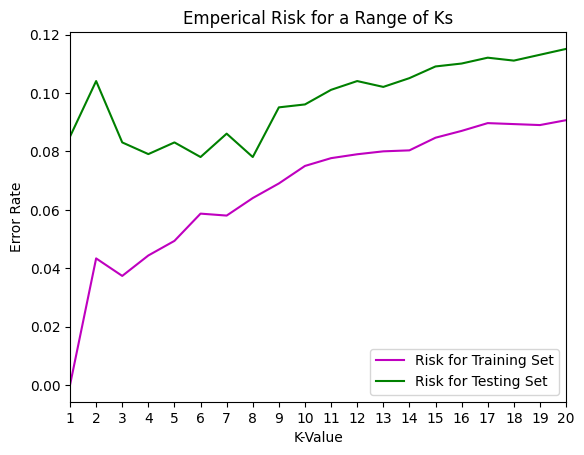

In [101]:
import matplotlib.pyplot as plt

plt.plot(k_list, errors_training, color='m', label='Risk for Training Set')
plt.plot(k_list, errors_testing, color='g', label='Risk for Testing Set')
plt.title('Emperical Risk for a Range of Ks')
plt.ylabel('Error Rate')
plt.xlabel('K-Value')
plt.xlim((1,20))
plt.xticks(list(range(1,21)))
plt.legend()
plt.show()

In [100]:
LOOCV_score = KNN_mult.loocv_score()

In [102]:
print(pd.DataFrame(LOOCV_score, columns=['LOOCV Score'], index=[i for i in k_list]))

    LOOCV Score
1      0.080694
2      0.088696
3      0.078693
4      0.079026
5      0.080027
6      0.083028
7      0.083361
8      0.089363
9      0.087696
10     0.090030
11     0.092031
12     0.094365
13     0.095032
14     0.094365
15     0.096032
16     0.098366
17     0.097366
18     0.100367
19     0.099033
20     0.101034


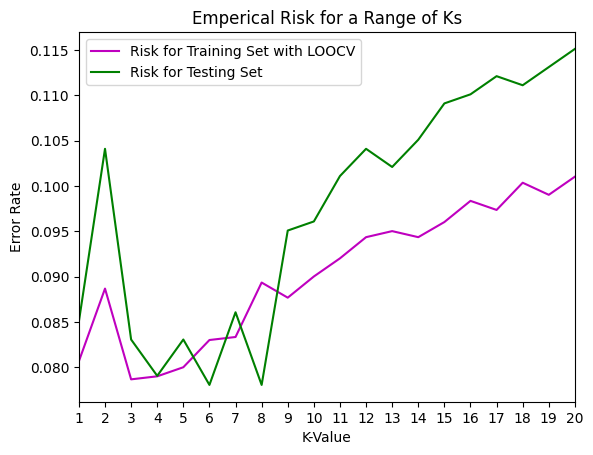

In [104]:
plt.plot(k_list, LOOCV_score, color='m', label='Risk for Training Set with LOOCV')
plt.plot(k_list, errors_testing, color='g', label='Risk for Testing Set')
plt.title('Emperical Risk for a Range of Ks')
plt.ylabel('Error Rate')
plt.xlabel('K-Value')
plt.xlim((1,20))
plt.xticks(list(range(1,21)))
plt.legend()
plt.show()

In [ ]:
dist_range = [i for i in range(1,16)]
dist_df = KNN_mult.grid_search_dist(dist_range=dist_range)

100%|██████████| 15/15 [7:49:32<00:00, 1878.15s/it]  


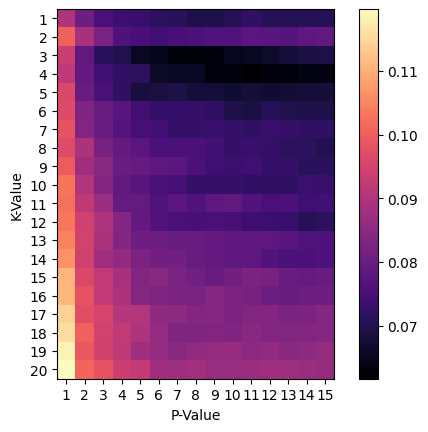

In [135]:
plt.imshow(dist_df, cmap='magma')
plt.xlabel('P-Value')
plt.ylabel('K-Value')
plt.xticks(ticks=range(0,15), labels=dist_range)
plt.yticks(ticks=range(0,20), labels=k_list)
plt.colorbar()
plt.show()

In [136]:
min_error = dist_df.to_numpy().min()
print(f"{min_error:.4f} error rate acheived at k={np.where(dist_df == min_error)[0][0]} and p={np.where(dist_df == min_error)[1][0]}")

0.0617 error rate acheived at k=3 and p=10


In [113]:
KNN_now = KNN(k=3)
KNN_now.fit(train_small_X, train_small_y)
p_perf = KNN_now.test_dist_perf(test_small_X, test_small_y, dist_range=dist_range)

100%|██████████| 15/15 [25:44<00:00, 102.99s/it]


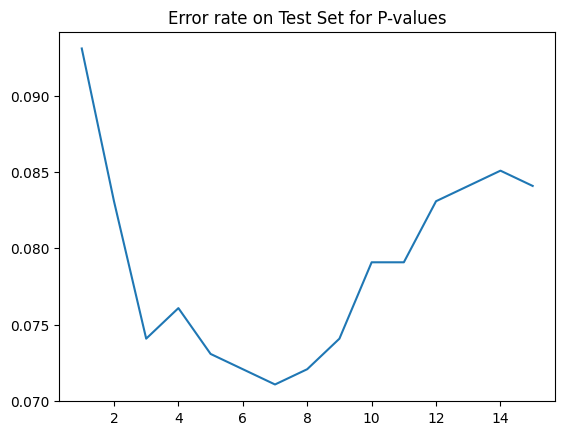

In [117]:
plt.plot(dist_range, p_perf)
plt.title('Error rate on Test Set for P-values')
plt.show()